In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ot
import scipy
import progressbar

In [2]:
sns.set_style('darkgrid')
plt.style.use(['default'])

## Functions

### Learning cost

In [3]:

def learn_cost_matrix(pi_hat, reg, niter = 400):
    mu = pi_hat.sum(axis=1).reshape(-1,1)
    nu = pi_hat.sum(axis=0).reshape(-1,1)
    alpha = np.ones((pi_hat.shape[0],1))
    beta = np.ones((pi_hat.shape[1],1))
    c = np.zeros(pi_hat.shape,dtype = 'float64')
    u = np.exp(alpha / reg)
    v = np.exp(beta / reg)
    for i in progressbar.progressbar(range(niter)):
        #K = np.empty(c.shape, dtype = c.dtype)
        #np.divide(c, -reg, out = K)
        K = np.exp(-c/reg)
        #print(check_symetric(K))
        u = mu / np.maximum(np.dot(K,v),1e-30)
        v = nu / np.maximum((np.dot(K,u)),1e-30)
        K =  np.maximum(pi_hat / (np.maximum(np.dot(u, v.T), 1e-30)), 1e-30)
        
        tmp = -reg * np.log(K)
        c_prev = c 
        c = 1/2*(tmp+tmp.T)
        np.fill_diagonal(c,0)
        c = np.maximum(0,c)

    return c,K

### Creating distance matrix for various type of distance

In [4]:
def compute_log_dist(shape):
    D = np.zeros((shape[0]*shape[1],shape[0]*shape[1]),dtype='float64')
    
    for i in progressbar.progressbar(range(len(D))):
        for j in range(i+1,len(D)):
            x1,y1 = np.unravel_index(i,shape)
            x2,y2 = np.unravel_index(j,shape)
            tmp = np.abs(x1-x2) + np.abs(y1-y2)
            D[i,j] = np.log(tmp + 1)
            D[j,i] = D[i,j]

    return D/D.max()

def compute_cubeud(shape):
    D = np.zeros((shape[0]*shape[1],shape[0]*shape[1]),dtype='float64')
    
    for i in progressbar.progressbar(range(len(D))):
        for j in range(i+1,len(D)):
            x1,y1 = np.unravel_index(i,shape)
            x2,y2 = np.unravel_index(j,shape)
            tmp = np.abs(x1-x2)**3 + np.abs(y1-y2)**3
            D[i,j] = tmp**(1./3.)
            D[j,i] = D[i,j]

    return D

def compute_WRF(shape):
    D = np.zeros((shape[0]*shape[1],shape[0]*shape[1]),dtype='float64')
    
    for i in progressbar.progressbar(range(len(D))):
        for j in range(i+1,len(D)):
            x1,y1 = np.unravel_index(i,shape)
            x2,y2 = np.unravel_index(j,shape)
            tmp = np.abs(x1-x2)**2 + np.abs(y1-y2)**2
            
            D[i,j] = tmp
            D[j,i] = D[i,j]

    return D/D.max()

def compute_canberra_matrix(image_shape):
    D = np.zeros((image_shape[0]*image_shape[1],image_shape[0]*image_shape[1]),dtype = 'float32')
    for i in progressbar.progressbar(range(1,len(D))): 
        for j in range(i+1, len(D)):
            x1,y1 = np.unravel_index(i,image_shape)
            x2,y2 = np.unravel_index(j,image_shape)
            if ((x1 == 0) and (x2 == 0)) : 
                tmpx = 1
            else : 
                tmpx= (x1 + x2)
            
            if ((y1==0) and (y2==0)) :
                tmpy =1
            else : 
                tmpy = y1+y2
            D[i,j] = np.float(np.abs(x1-x2))/(tmpx) + np.float(np.abs(y1-y2))/(tmpy)
            D[j,i] = D[i,j]
            
    return D 


def compute_distance_matrix(image_shape):
    D = np.zeros((image_shape[0]*image_shape[1],image_shape[0]*image_shape[1]),dtype = 'float32')
    
    for i in progressbar.progressbar(range(len(D))): 
        for j in range(i+1, len(D)):
            x1,y1 = np.unravel_index(i,image_shape)
            x2,y2 = np.unravel_index(j,image_shape)
            D[i,j] = ((x1-x2)**2 + (y1-y2)**2)**(1./2.)
            D[j,i] = D[i,j]
            
    return D 

def compute_vpen_matrix(image_shape):
    D = np.zeros((image_shape[0]*image_shape[1],image_shape[0]*image_shape[1]),dtype = 'float32')
    
    for i in progressbar.progressbar(range(len(D))): 
        for j in range(i+1, len(D)):
            x1,y1 = np.unravel_index(i,image_shape)
            x2,y2 = np.unravel_index(j,image_shape)
            D[i,j] = ((x1-x2)**2 + 10*(y1-y2)**2)**(1./2.)
            D[j,i] = D[i,j]
            
    return D 

### Utils

In [5]:
def check_symetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def sinkhorn_knopp(a, b, M, reg, numItermax=1000,
                   stopThr=1e-9, verbose=False, log=False, **kwargs):
    r"""
    Slight Variation of a function provided in library POT (see references)
    References
    ----------
    .. [2] M. Cuturi, Sinkhorn Distances : Lightspeed Computation of Optimal Transport, Advances in Neural Information Processing Systems (NIPS) 26, 2013

    """

    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)

    if len(a) == 0:
        a = np.ones((M.shape[0],), dtype=np.float64) / M.shape[0]
    if len(b) == 0:
        b = np.ones((M.shape[1],), dtype=np.float64) / M.shape[1]

    # init data
    dim_a = len(a)
    dim_b = len(b)

    if len(b.shape) > 1:
        n_hists = b.shape[1]
    else:
        n_hists = 0

    if log:
        log = {'err': []}


    if n_hists:
        u = np.ones((dim_a, n_hists)) / dim_a
        v = np.ones((dim_b, n_hists)) / dim_b
    else:
        u = np.ones(dim_a) / dim_a
        v = np.ones(dim_b) / dim_b


    # Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
    K = np.empty(M.shape, dtype=M.dtype)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    # print(np.min(K))
    tmp2 = np.empty(b.shape, dtype=M.dtype)

    Kp = (1 / np.maximum(a,1e-30)).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        
        v = np.divide(b, KtransposeU)
        u = 1. / np.dot(Kp, v)

        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            if n_hists:
                np.einsum('ik,ij,jk->jk', u, K, v, out=tmp2)
            else:
                # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
                np.einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 200 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        cpt = cpt + 1
    if log:
        log['u'] = u
        log['v'] = v

    if n_hists:  # return only loss
        res = np.einsum('ik,ij,jk,ij->k', u, K, v, M)
        if log:
            return res, log
        else:
            return res

    else:  # return OT matrix

        if log:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1)), log
        else:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1))

## Experiment

In [6]:
f1 =plt.imread('./2D_goodshape_tries/redcross.png')[:,:,3]

f2 =1- plt.imread('./2D_goodshape_tries/duck.png')

A = []
f1 = f1[::5,::5] / np.sum(f1[::5,::5])
f2 = f2[::5,::5] / np.sum(f2[::5,::5])

A.append(f1)
A.append(f2)

A = np.array(A)

In [7]:
M_sqed = compute_distance_matrix(f1.shape)
M_sqed /= M_sqed.max()

100% (2601 of 2601) |####################| Elapsed Time: 0:00:27 Time:  0:00:27


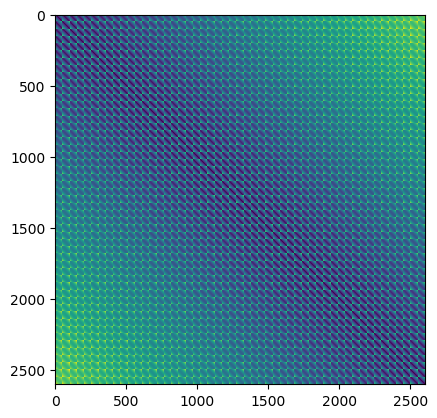

In [8]:
plt.imshow(M_sqed)

In [9]:
noisy_f1 = f1 + 1/10000 * np.random.rand(51,51)
noisy_f2 = f2 + 1/10000 * np.random.rand(51,51)
noisy_f1 /= noisy_f1.sum()
noisy_f2 /= noisy_f2.sum()

In [10]:
pi = sinkhorn_knopp(noisy_f1.ravel(),noisy_f2.ravel(),M_sqed,.1)

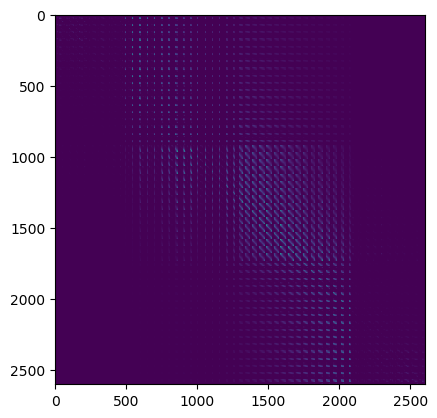

In [11]:
plt.imshow(pi)

In [12]:
cost = learn_cost_matrix(pi,.1)

100% (400 of 400) |######################| Elapsed Time: 0:03:13 Time:  0:03:13


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

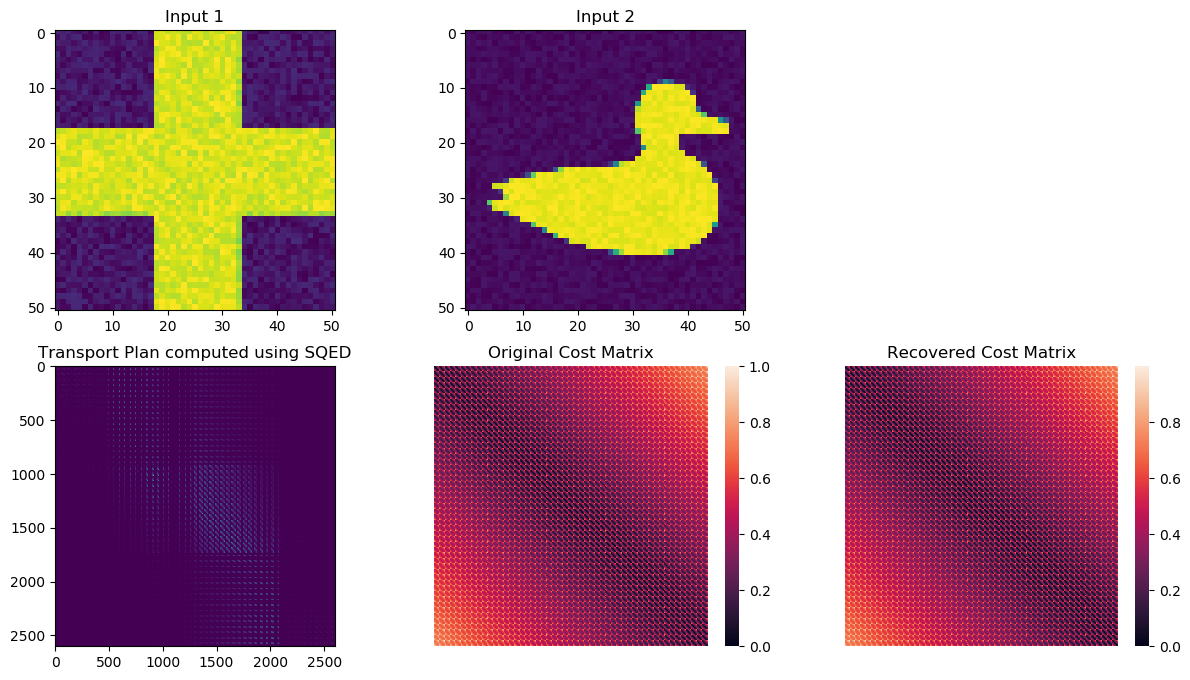

In [13]:
plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(noisy_f1)
plt.title('Input 1')
plt.subplot(232)
plt.imshow(noisy_f2)
plt.title('Input 2')
plt.subplot(234)
plt.imshow(pi)
plt.title('Transport Plan computed using SQED')
plt.subplot(235)
ax = sns.heatmap(M_sqed)
ax.tick_params(left=False, bottom=False, labelbottom = False, labelleft = False)
plt.title('Original Cost Matrix')
plt.subplot(236)
ax = sns.heatmap(cost[0])
ax.tick_params(left=False, bottom=False, labelbottom = False , labelleft = False)
plt.title('Recovered Cost Matrix')

plt.tight_layout

#### Error evaluation

In [14]:
cost_n = cost[0]/cost[0].sum()

In [15]:
M_sqed_n = M_sqed/M_sqed.sum()

In [16]:
np.linalg.norm(cost_n-M_sqed_n)/np.linalg.norm(M_sqed_n) #Criterion used in the paper we work on for the inverse problem

0.011028839161670622

## Experiment with non-noisy inputs

In [17]:
pi_2 = sinkhorn_knopp(f1.ravel(),f2.ravel(),M_sqed,1)

In [18]:
cost_2 = learn_cost_matrix(pi_2,1)

100% (400 of 400) |######################| Elapsed Time: 0:03:20 Time:  0:03:20


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

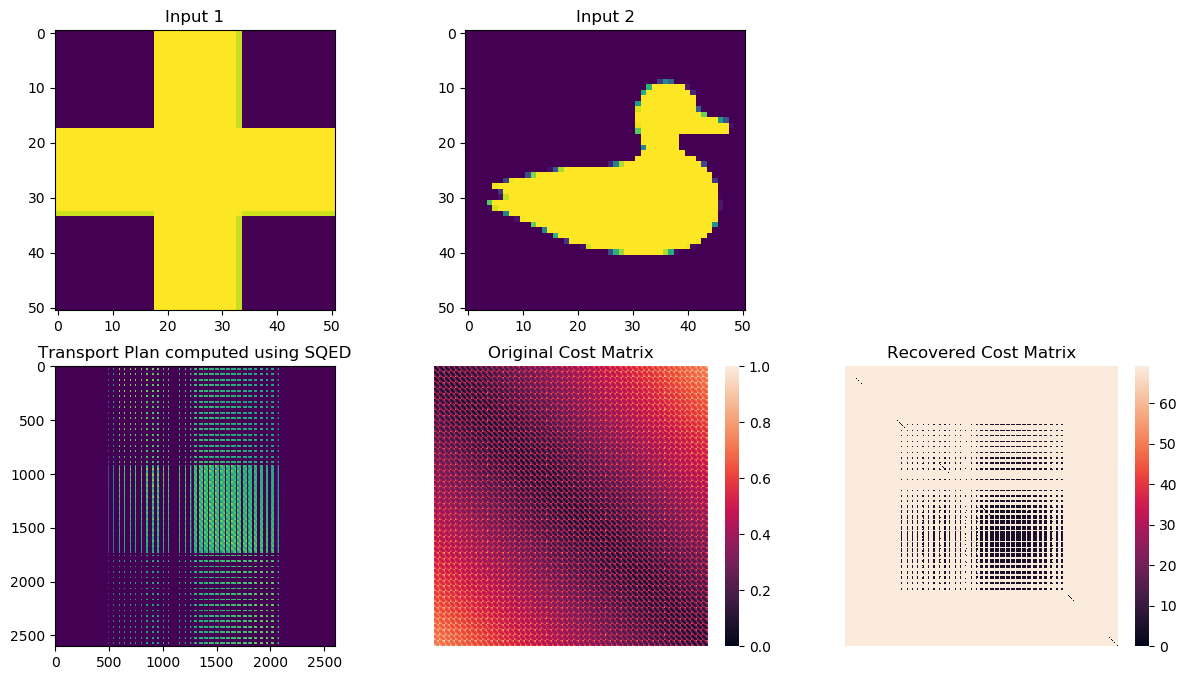

In [19]:
plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(f1)
plt.title('Input 1')
plt.subplot(232)
plt.imshow(f2)
plt.title('Input 2')
plt.subplot(234)
plt.imshow(pi_2)
plt.title('Transport Plan computed using SQED')
plt.subplot(235)
ax = sns.heatmap(M_sqed)
ax.tick_params(left=False, bottom=False, labelbottom = False, labelleft = False)
plt.title('Original Cost Matrix')
plt.subplot(236)
ax = sns.heatmap(cost_2[0])
ax.tick_params(left=False, bottom=False, labelbottom = False , labelleft = False)
plt.title('Recovered Cost Matrix')

plt.tight_layout

## Further Experiments with other cost functions

100% (2601 of 2601) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (400 of 400) |######################| Elapsed Time: 0:03:09 Time:  0:03:09


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

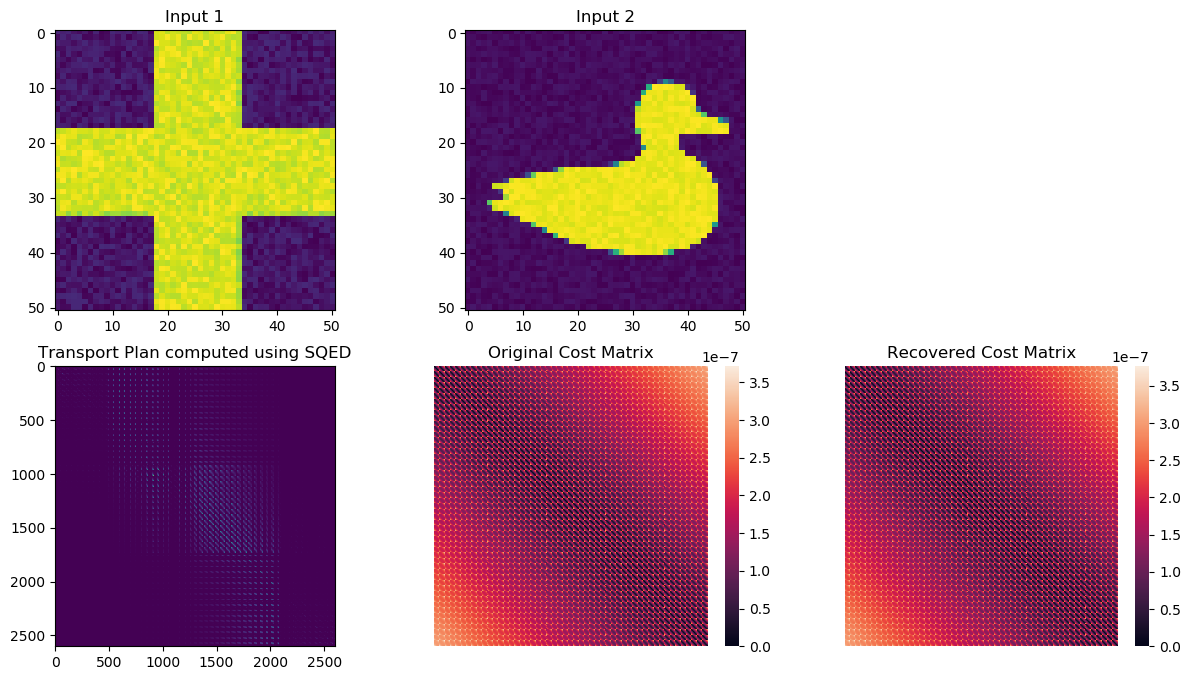

In [21]:
M_cubeud = compute_cubeud(f1.shape)
M_cubeud /= M_cubeud.max()

pi_cubeud = sinkhorn_knopp(noisy_f1.ravel(),noisy_f2.ravel(),M_cubeud,.1)
cost_cubeud = learn_cost_matrix(pi_cubeud,1)

plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(noisy_f1)
plt.title('Input 1')
plt.subplot(232)
plt.imshow(noisy_f2)
plt.title('Input 2')
plt.subplot(234)
plt.imshow(pi_cubeud)
plt.title('Transport Plan computed using SQED')
plt.subplot(235)
ax = sns.heatmap(M_cubeud/M_cubeud.sum())
ax.tick_params(left=False, bottom=False, labelbottom = False, labelleft = False)
plt.title('Original Cost Matrix')
plt.subplot(236)
ax = sns.heatmap(cost_cubeud[0]/cost_cubeud[0].sum())
ax.tick_params(left=False, bottom=False, labelbottom = False , labelleft = False)
plt.title('Recovered Cost Matrix')

plt.tight_layout

100% (2600 of 2600) |####################| Elapsed Time: 0:00:42 Time:  0:00:42
100% (400 of 400) |######################| Elapsed Time: 0:03:14 Time:  0:03:14


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

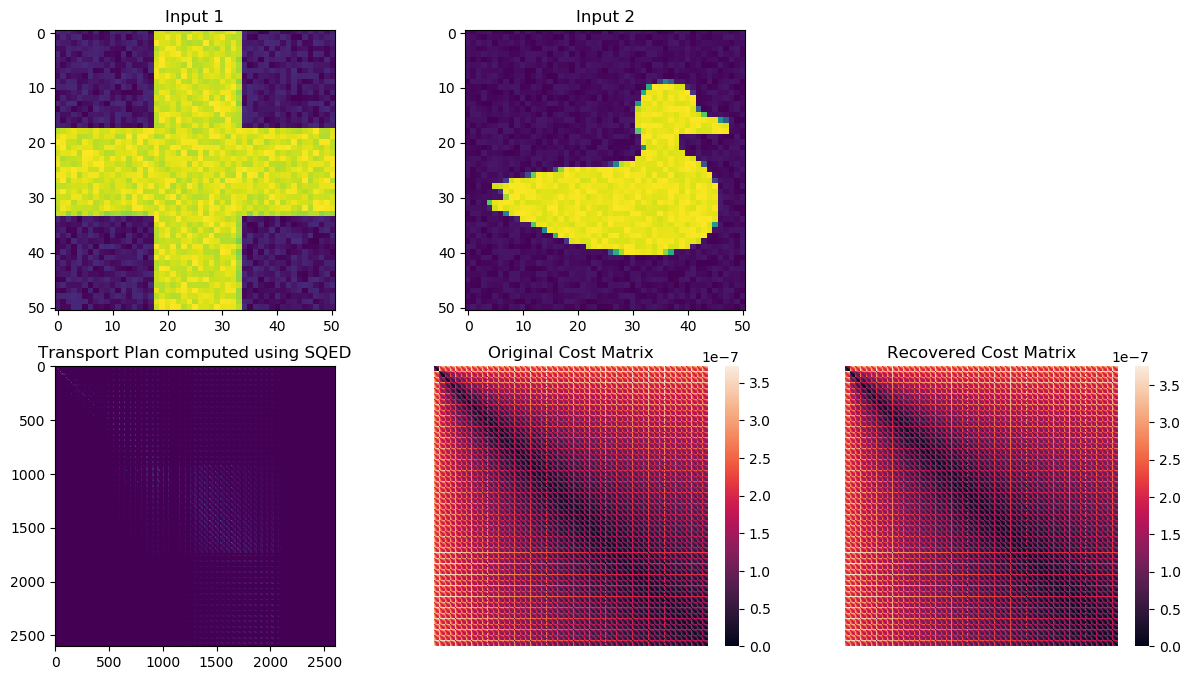

In [22]:
M_canberra = compute_canberra_matrix(f1.shape)
M_canberra /= M_canberra.max()

pi_canberra = sinkhorn_knopp(noisy_f1.ravel(),noisy_f2.ravel(),M_canberra,.1)
cost_canberra = learn_cost_matrix(pi_canberra,1)

plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(noisy_f1)
plt.title('Input 1')
plt.subplot(232)
plt.imshow(noisy_f2)
plt.title('Input 2')
plt.subplot(234)
plt.imshow(pi_canberra)
plt.title('Transport Plan computed using SQED')
plt.subplot(235)
ax = sns.heatmap(M_canberra/M_canberra.sum())
ax.tick_params(left=False, bottom=False, labelbottom = False, labelleft = False)
plt.title('Original Cost Matrix')
plt.subplot(236)
ax = sns.heatmap(cost_canberra[0]/cost_canberra[0].sum())
ax.tick_params(left=False, bottom=False, labelbottom = False , labelleft = False)
plt.title('Recovered Cost Matrix')

plt.tight_layout

100% (2601 of 2601) |####################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (400 of 400) |######################| Elapsed Time: 0:03:18 Time:  0:03:18


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

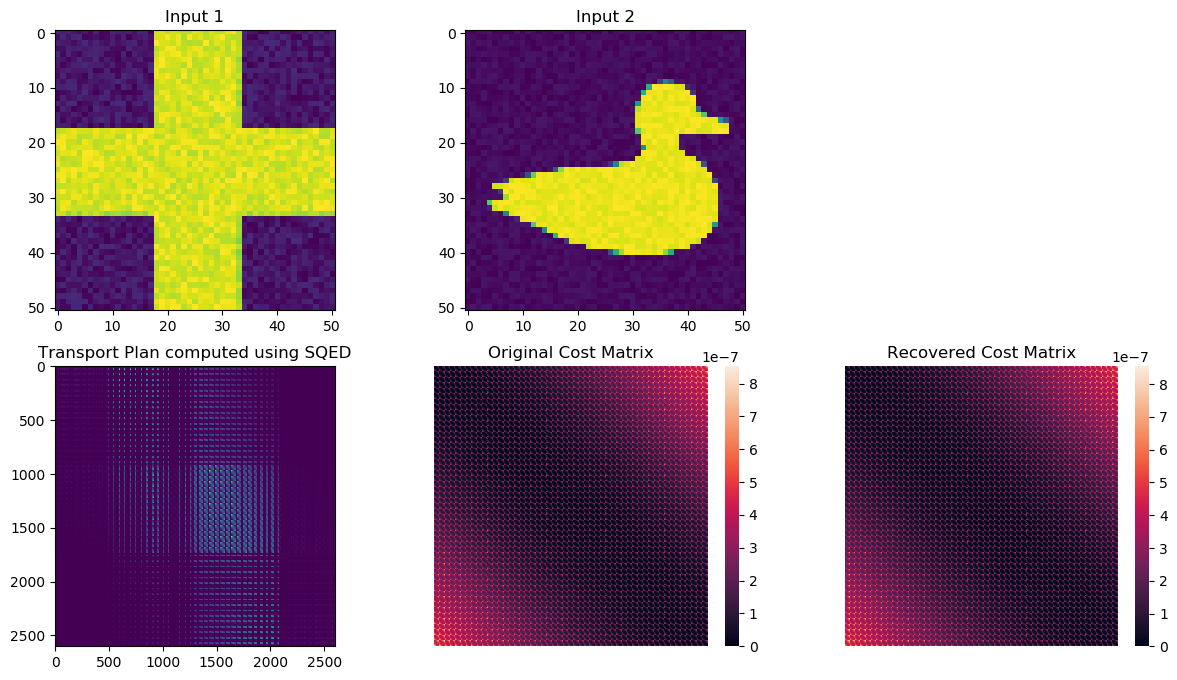

In [23]:
M_WRF = compute_WRF(f1.shape)
M_WRF /= M_WRF.max()

pi_WRF = sinkhorn_knopp(noisy_f1.ravel(),noisy_f2.ravel(),M_WRF,.1)
cost_WRF = learn_cost_matrix(pi_WRF,1)

plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(noisy_f1)
plt.title('Input 1')
plt.subplot(232)
plt.imshow(noisy_f2)
plt.title('Input 2')
plt.subplot(234)
plt.imshow(pi_WRF)
plt.title('Transport Plan computed using SQED')
plt.subplot(235)
ax = sns.heatmap(M_WRF/M_WRF.sum())
ax.tick_params(left=False, bottom=False, labelbottom = False, labelleft = False)
plt.title('Original Cost Matrix')
plt.subplot(236)
ax = sns.heatmap(cost_WRF[0]/cost_WRF[0].sum())
ax.tick_params(left=False, bottom=False, labelbottom = False , labelleft = False)
plt.title('Recovered Cost Matrix')

plt.tight_layout

100% (2601 of 2601) |####################| Elapsed Time: 0:00:32 Time:  0:00:32
100% (400 of 400) |######################| Elapsed Time: 0:03:11 Time:  0:03:11


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

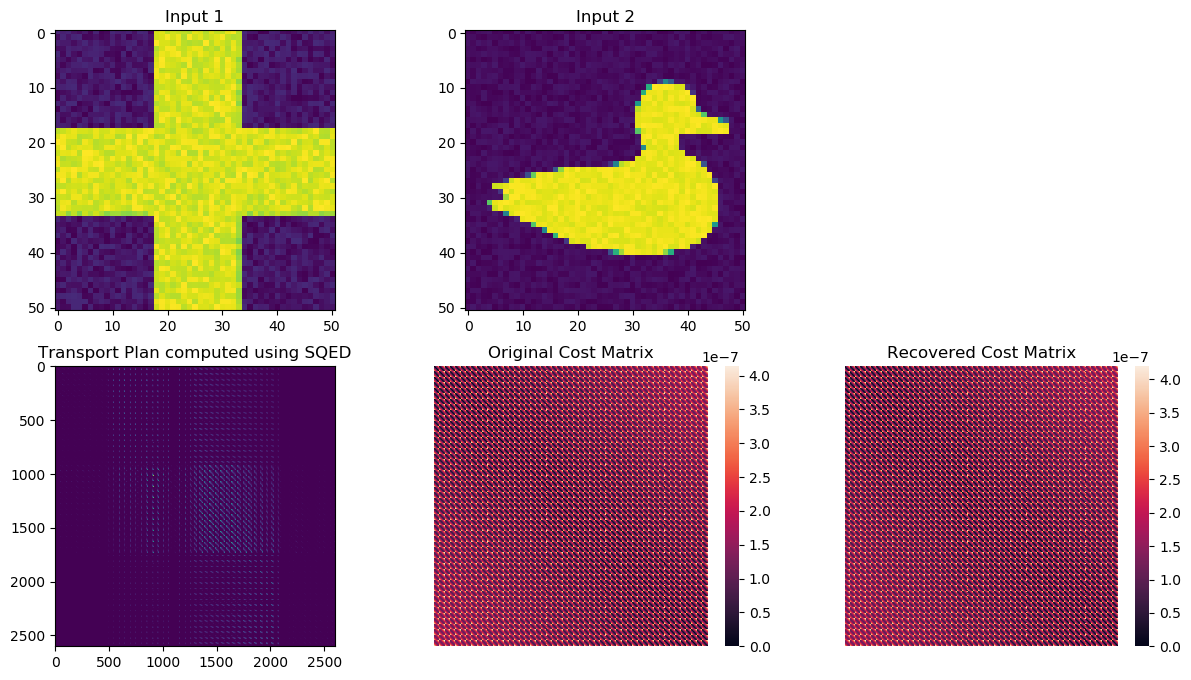

In [24]:
M_vpen = compute_vpen_matrix(f1.shape)
M_vpen /= M_vpen.max()

pi_vpen = sinkhorn_knopp(noisy_f1.ravel(),noisy_f2.ravel(),M_vpen,.1)
cost_vpen = learn_cost_matrix(pi_vpen,1)

plt.figure(figsize=(15,8))
plt.subplot(231)
plt.imshow(noisy_f1)
plt.title('Input 1')
plt.subplot(232)
plt.imshow(noisy_f2)
plt.title('Input 2')
plt.subplot(234)
plt.imshow(pi_vpen)
plt.title('Transport Plan computed using SQED')
plt.subplot(235)
ax = sns.heatmap(M_vpen/M_vpen.sum())
ax.tick_params(left=False, bottom=False, labelbottom = False, labelleft = False)
plt.title('Original Cost Matrix')
plt.subplot(236)
ax = sns.heatmap(cost_vpen[0]/cost_vpen[0].sum())
ax.tick_params(left=False, bottom=False, labelbottom = False , labelleft = False)
plt.title('Recovered Cost Matrix')

plt.tight_layout